# Apriori and LogCluster

See:
* http://ristov.github.io/logcluster/
* https://github.com/ristov/logcluster
* https://github.com/markuskont/kirka/blob/master/algorithms/LogCluster.py

## Apriori

Apriori is an algorithm for frequent itemset mining on transactional databases. In other words, it is used to find data elements that commonly occur together given a user-defined support value $S$. First, lets define some data.

In [356]:
transactions = [
    ["apple", "beer", "rice", "meat"],
    ["apple", "beer", "rice"],
    ["apple", "beer"],
    ["apple", "pear"],
    ["milk", "beer", "rice", "meat"],
    ["milk", "beer", "rice"],
    ["milk", "beer"],
    ["milk", "pear"]
]

We need to know the occurrence count of all items, along with total number of transactions.

In [357]:
counters = {}
for t in transactions:
    for item in t:
        if item not in counters:
            counters[item] = 1
        else:
            counters[item] += 1
counters

{'apple': 4, 'beer': 6, 'meat': 2, 'milk': 4, 'pear': 2, 'rice': 4}

This allows us to calculate support values for each item, relative to total number of transactions.

In [358]:
total = len(transactions)
total

8

In [359]:
support = {}
for k, v in counters.items():
    support[k] = v/total
    
support

{'apple': 0.5,
 'beer': 0.75,
 'meat': 0.25,
 'milk': 0.5,
 'pear': 0.25,
 'rice': 0.5}

Now, we will need to find likelyhoods that two items appear together, or confidence values for items $\{X -> Y\}$.

In [360]:
import pandas as pd
import numpy as np

df = pd.DataFrame(0, columns = support.keys(), index = support.keys())
np.fill_diagonal(df.values, 1)

In [361]:
for x in support.keys():
    xy = []
    for y in support.keys():
        count = 0
        for t in transactions:
            if x != y:
                if x in t and y in t:
                    count += 1
            #else:
            #    count = None
        xy.append(count)
    df[x] = xy

In [362]:
totals = list(counters.values())
confidence = df.divide(totals, axis = "index")
s = list(support.values())
supports_mult = pd.DataFrame(0, columns = support.keys(), index = support.keys())

support_outer = np.outer(np.array(s), np.array(s))
support_outer = pd.DataFrame(support_outer, columns = support.keys(), index = support.keys())

lift = df / support_outer

Subsequently, infrequent itemsets that do not meet support criterium can be dropped.

## Logfile clustering

This core idea can be extended to identify frequently appearing patterns in unstructured event log messages. Firstly, we will read a syslog file and generate word counter not unlike "bag of words" that is used for text data mining.

In [446]:
src = "/home/jovyan/data/SDM/logs/pacman.log"
splitOn = "\s+|\.|/|\"|\(|\)|:"

In [447]:
import re

In [448]:
words = {}
lines = 0
with open(src) as f:
    for line in f:
        lines =+ 1
        for w in re.split(splitOn, line):
            if w != "":
                if w not in words:
                    words[w] = 1
                else:
                    words[w] += 1

In [449]:
len(words)

1979

<function matplotlib.pyplot.show>

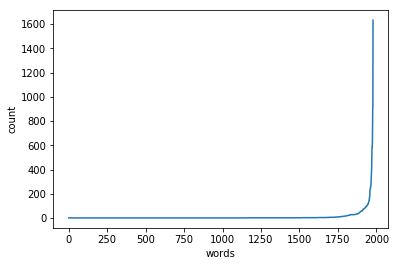

In [450]:
import matplotlib.pyplot as plt
plt.plot(sorted(list(words.values())))
plt.ylabel('count')
plt.xlabel('words')
plt.show

After counting distinct words, we see that majority of the words are infrequent. So we will define a threshold and drop those words.

In [451]:
sup = 50
for word in list(words.keys()):
    if words[word] < sup:
        del words[word]
        
fwords = list(words.keys())
len(fwords)

84

Now we will need to do a second pass over input file to create cluster candidates. Only frequent words will be kept in cluster candidates while infrequent words are replaced by wildcards.

In [452]:
import json
import hashlib

candidates = {}
lines = 0
with open(src) as f:
    for line in f:
        lines += 1
        candidate = []
        wildcards = []
        noWildcards = 0
        for w in re.split(splitOn, line):
            if w != "" and w in fwords:
                candidate.append(w)
                wildcards.append(noWildcards)
                noWildcards = 0
            else:
                noWildcards += 1
        ident = hashlib.md5(json.dumps(sorted(candidate)).encode()).hexdigest()
        
        if ident not in candidates:
            candidates[ident] = {
                "count": 1,
                "words": candidate,
                "wildcards": wildcards
            }
        else:
            candidates[ident]["count"] += 1
        
        #if lines%1000==0:
        #    print(ident)
        #    print(wildcards)

In [453]:
len(candidates)

1151

In [454]:
counts = []
for k, v in candidates.items():
    counts.append(v["count"])

<function matplotlib.pyplot.show>

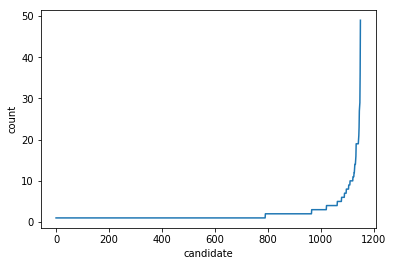

In [455]:
plt.plot(sorted(counts))
plt.ylabel('count')
plt.xlabel('candidate')
plt.show

We can observe a similar case for candidate counters as we did for words - only a small subset of candidates occur most amount of time. We can now use the same support values as before, or define a new one to repeat dropping infrequent items.

In [456]:
sup = 10
for k in list(candidates.keys()):
    v = candidates[k]
    if v["count"] < sup:
        del candidates[k]
clusters = candidates
len(clusters)

40

In [457]:
for cluster in list(clusters.values()):
    i = 0
    wildcards = cluster['wildcards']
    for word in cluster['words']:
        wc = wildcards[i]
        print(word, end=' ')
        if wc > 0:
            print('*'*wc, end=' ')
        i += 1
    print()

[2017-12-21 20 29] [ALPM] installed 
[2017-12-21 20 29] [ALPM] installed 2 ** 
[2017-12-21 20 29] [ALPM] installed 1 ** 
[2017-12-21 20 29] [ALPM-SCRIPTLET] 
[2017-12-21 20 29] [ALPM-SCRIPTLET] -> Running build hook 
[2017-12-21 20 39] [ALPM] installed 0 ** 
[2017-12-21 20 39] [ALPM] installed 1 ** 
[2017-12-21 20 39] [ALPM] installed 1 ** 0 
[2017-12-21 20 39] [ALPM] installed 2 ** 0 
[2017-12-21 20 39] [ALPM] installed 2 ** 
[2017-12-21 20 39] [ALPM-SCRIPTLET] 
[2017-12-21 20 39] [ALPM] installed 1 ** 1 
[2017-12-21 20 39] [ALPM] installed 1 ** 2 
[2017-12-21 20 39] [ALPM] installed 
[2017-12-21 20 39] [ALPM] installed 3 ** 26 
[2017-12-21 20 39] [ALPM-SCRIPTLET] -> Running build hook 
[2017-12-21 20 40] [ALPM] running hook' * 
[2017-12-21 21 [PACMAN] * Running 'pacman -Sy 
[2017-12-21 21 [PACMAN] * synchronizing package lists 
[2017-12-22 21 [ALPM-SCRIPTLET] * -> Running build hook 
[2017-12-23 16 22] [ALPM-SCRIPTLET] 
[2017-12-30 00 11] [ALPM-SCRIPTLET] -> Running build hook 
[2018

We can now run another pass over the data to report all infrequent